In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from utils import *
from tqdm import tqdm

In [2]:
df = pd.read_csv('feature_extraction.csv')

In [3]:
ACC_LIST = [i for i in range(2, 38)]
AE_LIST = [i for i in range(38, 50)]
FORCE_LIST = [i for i in range(50, 86)]


### 전체 Feature (86개) 사용

In [4]:
X = df.iloc[:, 2:-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 데이터 정규화
normalizer = Normalize()
X_train, X_test, y_train, y_test = normalizer.normalize_data(X_train, X_test, y_train, y_test)

### ACC, FORCE Feature (72개) 사용

In [1]:
X = df.iloc[:, ACC_LIST+FORCE_LIST].values
y = df.iloc[:, -1].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
train_indices = [i for i in range(60)] + [i for i in range(72, 96)]
test_indices = [i for i in range(60, 72)]
X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

# 데이터 정규화
X_train, X_test, y_train, y_test = normalize_data(X_train, X_test, y_train, y_test)


NameError: name 'df' is not defined

### SVR Model

Train Data Performance
RMSE:  25.117233549479263
R^2:  0.8740081858420887
Test Data Performance
RMSE:  37.607734979899575
R^2:  0.615286981470773


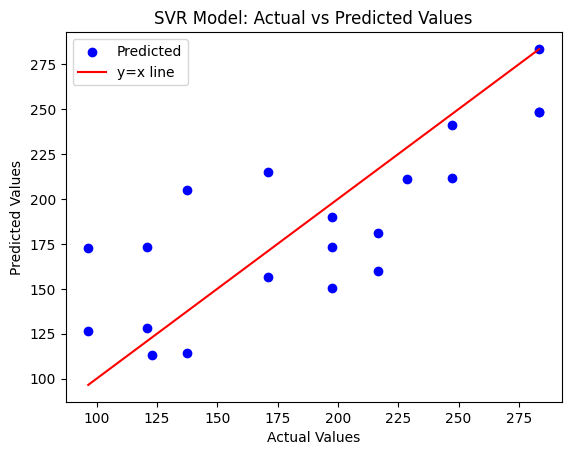

In [7]:
# 3. 모델 학습
# SVR 모델 생성 및 학습
svr_rbf = SVR(kernel='rbf', C=1)
svr_rbf.fit(X_train, y_train)

# 4. 모델 평가
# 예측 수행
y_pred_train = svr_rbf.predict(X_train)
y_pred_test = svr_rbf.predict(X_test)

# 역정규화
y_train_original = normalizer.inverse_normalize_data(y_train.reshape(-1, 1)).ravel()
y_pred_train_original = normalizer.inverse_normalize_data(y_pred_train.reshape(-1, 1)).ravel()
y_test_original = normalizer.inverse_normalize_data(y_test.reshape(-1, 1)).ravel()
y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test.reshape(-1, 1)).ravel()

# 모델 성능 평가
mse_train = mean_squared_error(y_train_original, y_pred_train_original)
r2_train = r2_score(y_train_original, y_pred_train_original)
mse_test = mean_squared_error(y_test_original, y_pred_test_original)
r2_test = r2_score(y_test_original, y_pred_test_original)

print('Train Data Performance')
print('RMSE: ', np.sqrt(mse_train))
print('R^2: ', r2_train)
print('Test Data Performance')
print('RMSE: ', np.sqrt(mse_test))
print('R^2: ', r2_test)

# 5. 결과 시각화
plt.scatter(y_test_original, y_pred_test_original, color='blue', label='Predicted')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', label='y=x line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Model: Actual vs Predicted Values')
plt.legend()
plt.show()

### RFR 모델

RMSE:  33.99215659721685
R^2:  0.6857031958153585


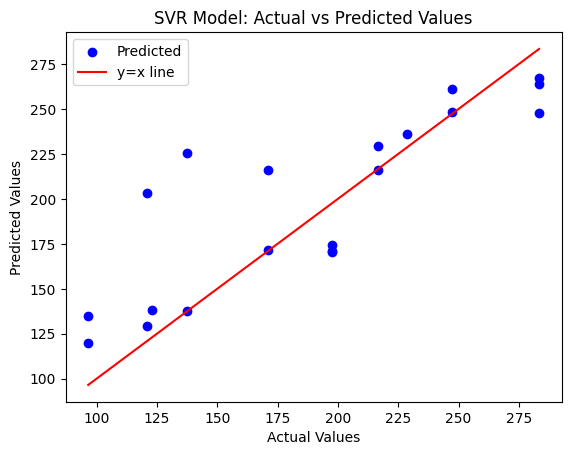

In [9]:
# 3. 모델 학습
# RFR 모델 생성 및 학습
rf_regressor = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_leaf=3)
rf_regressor.fit(X_train, y_train)

# 4. 모델 평가
# 예측 수행
y_pred = rf_regressor.predict(X_test)

# 역정규화
y_test_original = normalizer.inverse_normalize_data(y_test.reshape(-1, 1)).ravel()
y_pred_original = normalizer.inverse_normalize_data(y_pred.reshape(-1, 1)).ravel()

# 모델 성능 평가
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print('RMSE: ', np.sqrt(mse))
print('R^2: ', r2)

# 5. 결과 시각화
plt.scatter(y_test_original, y_pred_original, color='blue', label='Predicted')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', label='y=x line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Model: Actual vs Predicted Values')
plt.legend()
plt.show()

### LSTM 모델

In [17]:

# 하이퍼파라미터 설정
input_size = 1
hidden_size = 1000
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 0.01
gradient_threshold = 1

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

# 모델 초기화
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in tqdm(range(num_epochs)):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_threshold)
    
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # 모델 예측
# model.eval()
# predictions = model(x_train).detach().numpy()

# # 결과 시각화
# plt.plot(y_train.numpy(), label='Actual')
# plt.plot(predictions, label='Predicted')
# plt.legend()
# plt.show()


 10%|█         | 50/500 [06:35<1:04:03,  8.54s/it]

Epoch [50/500], Loss: 0.1007


 20%|██        | 100/500 [13:45<55:25,  8.31s/it] 

Epoch [100/500], Loss: 0.0965


 30%|███       | 150/500 [20:49<53:23,  9.15s/it]

Epoch [150/500], Loss: 0.1026


 40%|████      | 200/500 [28:02<44:33,  8.91s/it]

Epoch [200/500], Loss: 0.1353


 50%|█████     | 250/500 [35:50<42:08, 10.11s/it]

Epoch [250/500], Loss: 0.2447


 60%|██████    | 300/500 [5:05:45<47:41:49, 858.55s/it] 

Epoch [300/500], Loss: 0.1284


 70%|███████   | 350/500 [5:50:21<20:35,  8.24s/it]     

Epoch [350/500], Loss: 0.4490


 80%|████████  | 400/500 [5:57:19<13:38,  8.18s/it]

Epoch [400/500], Loss: 0.0999


 90%|█████████ | 450/500 [6:04:15<06:57,  8.36s/it]

Epoch [450/500], Loss: 0.1025


100%|██████████| 500/500 [6:12:37<00:00, 44.72s/it]

Epoch [500/500], Loss: 0.1347
